In [19]:
import numpy as np
from matplotlib import pyplot as plt
import ase.io as aio

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto

from ase import Atoms
from ase.units import Bohr

from scipy.stats import linregress

In [20]:
def get_nuc_rep(xyz, spin):
    atoms = aio.read(xyz)
    
    nuc = atoms.get_atomic_numbers()[np.where(atoms.get_atomic_numbers() > 1)]
    pos = atoms.get_positions()[np.where(atoms.get_atomic_numbers() > 1)]
    d = atoms.get_distance(0,1)
    atoms_heavy = Atoms(numbers=nuc, positions=pos)
#     print(atoms_heavy.get_distance(0,1))
    if nuc.sum()%2:
        spin = 1
    else:
        spin = 0
    
#     print(atoms.get_distance(0,1))
#     print(np.linalg.norm(pos[0]-pos[1]))

#     print(np.linalg.norm(pos[0]-pos[1])/Bohr)
    atoms_pyscf = uqm.ase2pyscf(atoms_heavy)
    mol = gto.Mole()
    mol.atom = atoms_pyscf
    mol.spin = spin
    mol.build()
    return(mol.energy_nuc(),d/Bohr)

def get_r2(predicted, ref):
    return(1 - ((predicted-ref)**2).sum()/((ref-ref.mean())**2).sum())

In [21]:
nuc_diatomics = dict()
dist = dict()
for s in ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']:
    nuc_diatomics[s], dist[s] = get_nuc_rep(f'/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/{s}/{s}_opt.xyz', 0)
    
binding_nuc = dict()
for k in nuc_diatomics.keys():
    binding_nuc[k] = nuc_diatomics[k]#-nuc_frag[k[0]]-nuc_frag[k[1]]

binding_nuc

{'CC': 12.477317636259505,
 'CN': 15.19934584414562,
 'CO': 17.87729673071805,
 'CF': 20.55822945099532,
 'NN': 18.127921992313123,
 'NO': 20.720373142108556,
 'NF': 23.310164030130572,
 'OO': 23.343021196765907,
 'OF': 26.651600980762268,
 'FF': 30.68555082411747}

In [4]:
dist

{'CC': 2.8852355188596244,
 'CN': 2.7632768185510477,
 'CO': 2.684969699575945,
 'CF': 2.6266853458885744,
 'NN': 2.703012515927464,
 'NO': 2.7026540329954543,
 'NF': 2.7026836860078847,
 'OO': 2.7417187991047927,
 'OF': 2.701526264798513,
 'FF': 2.639678867711708}

In [22]:
ref_bde = np.array([359.2, 337.7, 370.2, 452, 259.6, 253.5, 283.6, 195.2, 194.9, 151.7])
bfe = -ref_bde*0.000381
bfe

nbfe = np.array(list(binding_nuc.values()))
d = np.array(list(dist.values()))
ebfe_exp = bfe-nbfe # electronic binding energy

In [23]:
coeff_mat = np.array([[2,0,0,0,12,0,0,0],[1,1,0,0,7,6,0,0],[1,0,1,0,8,0,6,0],[1,0,0,1,9,0,0,6],
[0,2,0,0,0,14,0,0],[0,1,1,0,0,8,7,0],[0,1,0,1,0,9,0,7],
 [0,0,2,0,0,0,16,0], [0,0,1,1,0,0,9,8],[0,0,0,2,0,0,0,18]])

coeffs, maen, rank, sg = np.linalg.lstsq(coeff_mat, ebfe_exp, rcond=None)

In [24]:
mae = np.abs(coeffs@coeff_mat.T-ebfe_exp).mean()

var_ue = ((coeffs@coeff_mat.T-ebfe_exp)**2).sum()
var_tot = ((ebfe_exp - ebfe_exp.mean())**2).sum()
r2 = 1 - var_ue/var_tot

print(f'MAE of EBFE in kJ/mol {mae}')
print(f'r2 of EBFE in (Ha) = {r2}')

MAE of EBFE in kJ/mol 0.06867083065519726
r2 of EBFE in (Ha) = 0.9997461625031101


In [25]:
ebfe_el = coeffs@coeff_mat.T
predicted_bde = -(ebfe_el + nbfe)

mae_final = np.abs(predicted_bde-ref_bde).mean()
r2_final = 1 - ((predicted_bde-ref_bde)**2).sum()/((ref_bde-ref_bde.mean())**2).sum()

print(f'MAE of BDE in in kJ/mol {mae_final}')
print(f'r2 of BDE in (Ha) = {r2_final}')

MAE of BDE in in kJ/mol 285.65112543999993
r2 of BDE in (Ha) = -10.325901647314442


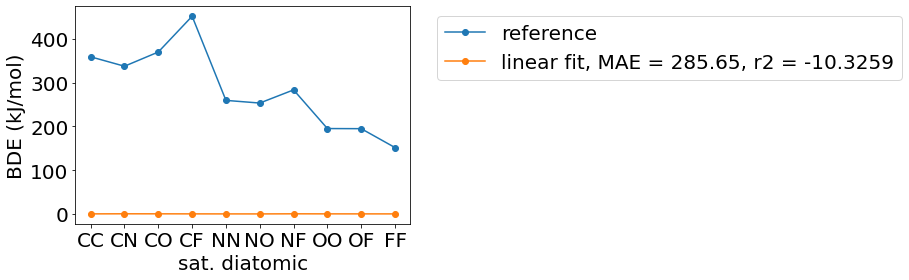

In [9]:
plt.rcParams['font.size'] = 20
plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], ref_bde, '-o',label = 'reference')
plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], predicted_bde, '-o',label = f'linear fit, MAE = {np.round(mae_final, 2)}, r2 = {np.round(r2_final, 4)}')
# plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], predicted_bde_opt, '-o',label = f'linear fit opt, MAE = {np.round(mae_opt, 2)*2600}, r2 = {np.round(r2_opt,4)}')

plt.ylabel('BDE (kJ/mol)')
plt.xlabel('sat. diatomic')
plt.legend(bbox_to_anchor = (1.05,1))

In [10]:
plt.plot(z73, coeffs[:4], '-o')

NameError: name 'z73' is not defined

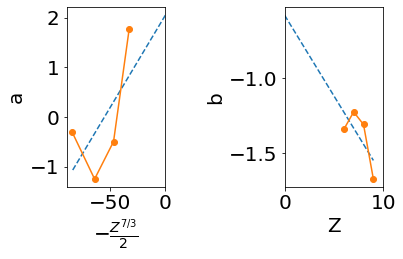

In [11]:
z = np.array([6, 7, 8, 9])
z73 = -0.5*z**(7/3)
a_fit = linregress(z73, coeffs[:4])
b_fit = linregress(z, coeffs[4:])

z_complete = np.arange(10)
z73_complete = -0.5*np.arange(10)**(7/3)

fig, ax = plt.subplots(1,2)

ax[0].plot(z73_complete, z73_complete*a_fit[0]+a_fit[1], '--')
ax[0].plot(z73, coeffs[:4], '-o')
ax[0].set_xlabel(r'$-\frac{Z^{7/3}}{2}$')
ax[0].set_ylabel('a')
ax[0].set_xlim([np.amin(z73_complete)-5,0 ])

ax[1].plot(z_complete, z_complete*b_fit[0]+b_fit[1], '--')
ax[1].plot(z, coeffs[4:], '-o')
ax[1].set_xlim([0,10])
ax[1].set_xlabel('Z')
ax[1].set_ylabel('b')

fig.tight_layout()

In [12]:
beta = a_fit[0]
b_prime = b_fit[0]

a_z_ni = lambda Z : -0.5*beta*Z**(7/3)# + a_fit[1]
a_z = lambda Z : -0.5*beta*Z**(7/3) + a_fit[1]

b_z_ni = lambda Z: b_prime*Z
b_z = lambda Z: b_prime*Z + b_fit[1]

In [13]:
coeffs_new = []
for i in z:
    coeffs_new.append(a_z(i))
    
for i in z:
    coeffs_new.append(b_z(i))
    
coeffs_new_ni = []
for i in z:
    coeffs_new_ni.append(a_z_ni(i))
    
for i in z:
    coeffs_new_ni.append(b_z_ni(i))
    
coeffs_new_a_ni = []
for i in z:
    coeffs_new_a_ni.append(a_z_ni(i))
    
for i in z:
    coeffs_new_a_ni.append(b_z(i))

In [14]:
ebfe_new = coeffs_new@coeff_mat.T
bde_new = -(ebfe_new+nbfe)
mae_new = np.abs(ebfe_new-ebfe_exp).mean()
print(mae_new)
r2_new = get_r2(ebfe_new, ebfe_exp)
print(r2_new)

0.22247557771175472
0.9965919162713227


In [15]:
ebfe_a_ni = coeffs_new_a_ni@coeff_mat.T
bde_new_a_ni = -(ebfe_a_ni+nbfe)
mae_new_a_ni = np.abs(ebfe_a_ni-ebfe_exp).mean()
print(mae_new_a_ni)
r2_a_ni = get_r2(ebfe_a_ni, ebfe_exp)
print(r2_a_ni)

4.100333324512387
0.3464228528864143


In [16]:
ebfe_ni = coeffs_new_ni@coeff_mat.T
bde_new_ni = -(ebfe_ni+nbfe)
mae_new_ni = np.abs(ebfe_ni-ebfe_exp).mean()
print(mae_new_ni)
r2_new_ni = get_r2(ebfe_ni, ebfe_exp)
print(r2_new_ni)

4.615607955868457
0.12105011499252227


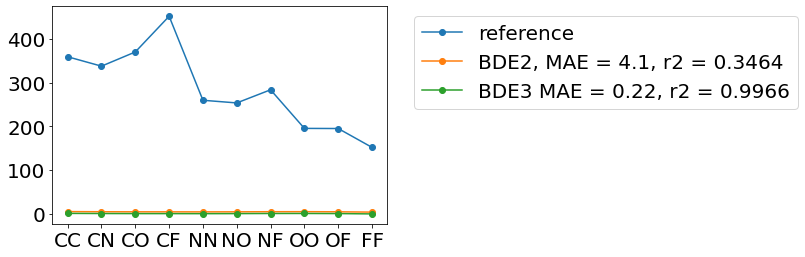

In [17]:
comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
plt.plot(comps, ref_bde, '-o',label = 'reference')
# plt.plot(comps, bde_new_ni, '-o',label = f'BDE1, MAE = {np.round(mae_new_ni, 2)}, r2 = {np.round(r2_new_ni, 4)}')
plt.plot(comps, bde_new_a_ni, '-o',label = f'BDE2, MAE = {np.round(mae_new_a_ni, 2)}, r2 = {np.round(r2_a_ni, 4)}')
plt.plot(comps, bde_new, '-o',label = f'BDE3 MAE = {np.round(mae_new, 2)}, r2 = {np.round(r2_new, 4)}')
plt.legend(bbox_to_anchor=(1.05,1))

$BDE = a_z + b_z \cdot Z' + a_{z'} + b_{z'} \cdot Z + E_\text{nuc}(Z, Z')$

Express $a_z$ and $b_z$ as linear functions in $f(Z)$

$BDE 1 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2 b' Z Z' + E_\text{nuc}(Z, Z')$ assume that in the fits for $a$ and $b$ intercept = 0

$BDE 2 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2 b' Z Z' + a' (Z + Z') + E_\text{nuc}(Z, Z')$ assume that in the fit for $a$ intercept = 0

$BDE 3 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2\alpha + 2 b' Z Z' + a' (Z + Z') + E_\text{nuc}(Z, Z')$ use intercepts from the fits

In [18]:
-beta/2*(z**(7/3))

array([-1.21665449, -1.74331729, -2.38062495, -3.13362387])

In [27]:
def ebfe_fit(Zs, beta, alpha, b_prime, a_prime):
    Z1, Z2 = Zs.T
#     for c in const:
#         if c == 'no_alpha':
#             alpha = 0
#         elif c == 'no_a_prime':
#             a_prime = 0
    return(-beta/2*(Z1**(7/3)+Z2**(7/3))+2*alpha+2*b_prime*Z1*Z2+2*a_prime*(Z1+Z2))


def ebfe_fit_ni(Zs, beta, b_prime):
    Z1, Z2 = Zs.T
    return(-beta/2*(Z1**(7/3)+Z2**(7/3))+2*b_prime*Z1*Z2)

def ebfe_fit_nalpha(Zs, beta, b_prime, a_prime):
    Z1, Z2 = Zs.T
    return(-beta/2*(Z1**(7/3)+Z2**(7/3))+2*b_prime*Z1*Z2+2*a_prime*(Z1+Z2))

def ebfe_fit_naprime(Zs, beta, alpha, b_prime):
    Z1, Z2 = Zs.T
    return(-beta/2*(Z1**(7/3)+Z2**(7/3))+2*alpha+2*b_prime*Z1*Z2)

def ebfe_fit_d(Zs, beta, alpha, c):
    Z1, Z2, d = Zs.T
    return(-beta/2*(Z1**(7/3)+Z2**(7/3))+2*alpha-2*c/d*Z1*Z2)

In [25]:
from scipy.optimize import curve_fit

In [33]:
xdata = np.array([[6,6], [6,7], [6,8], [6,9], [7,7], [7,8], [7,9], [8,8], [8,9], [9,9]])
z = np.array([6,7,8,9])
xdata2 = []
dc = 0
for i in range(len(z)):
    for j in range(i, len(z)):
        
        xdata2.append([z[i], z[j], d[dc]])
        dc = dc +1
xdata2 = np.array(xdata2)

In [19]:
dist

{'CC': 2.8852355188596244,
 'CN': 2.7632768185510477,
 'CO': 2.684969699575945,
 'CF': 2.6266853458885744,
 'NN': 2.703012515927464,
 'NO': 2.7026540329954543,
 'NF': 2.7026836860078847,
 'OO': 2.7417187991047927,
 'OF': 2.701526264798513,
 'FF': 2.639678867711708}

In [20]:
xdata2

[[6, 6, 2.8852355188596244],
 [6, 7, 2.7632768185510477],
 [6, 8, 2.684969699575945],
 [6, 9, 2.6266853458885744],
 [7, 7, 2.703012515927464],
 [7, 8, 2.7026540329954543],
 [7, 9, 2.7026836860078847],
 [8, 8, 2.7417187991047927],
 [8, 9, 2.701526264798513],
 [9, 9, 2.639678867711708]]

In [39]:
out = curve_fit(ebfe_fit, xdata, ebfe_exp)
# out[0]
bde_fit = -(ebfe_fit(xdata, out[0][0], out[0][1], out[0][2], out[0][3]) + nbfe)
mae = np.abs(bde_fit-ref_bde).mean()


In [47]:
out

(array([  18.67880519, -537.30838112, -462.41542044,   15.66909458]),
 array([[ 6.75813400e-01, -4.17838915e+01,  1.20944588e-01,
          4.89608056e+00],
        [-4.17838915e+01,  4.31509424e+03,  2.22219404e+01,
         -5.29967847e+02],
        [ 1.20944588e-01,  2.22219404e+01,  5.51996412e-01,
         -3.10142615e+00],
        [ 4.89608056e+00, -5.29967847e+02, -3.10142615e+00,
          6.56035208e+01]]))

In [41]:
out_ni = curve_fit(ebfe_fit_ni, xdata, ebfe_exp)

bde_fit_ni = -(ebfe_fit_ni(xdata, out_ni[0][0], out_ni[0][1]) + nbfe)

mae_ni = np.abs(bde_fit_ni-ref_bde).mean()


In [46]:
out_ni

(array([  -9.58407422, -496.06191681]),
 array([[101.92273912, 103.40019057],
        [103.40019057, 105.06650346]]))

In [32]:
out_nalpha = curve_fit(ebfe_fit_nalpha, xdata, ebfe_exp)

bde_fit_nalpha = -(ebfe_fit_nalpha(xdata, out_nalpha[0][0], out_nalpha[0][1], out_nalpha[0][2]) + nbfe)

mae_nalpha = np.abs(bde_fit_nalpha-ref_bde).mean()


In [48]:
out_nalpha

(array([  13.47596227, -459.64837989,  -50.32155318]),
 array([[ 2.82467406,  3.50073598, -2.45483331],
        [ 3.50073598,  4.55716954, -3.87636323],
        [-2.45483331, -3.87636323,  5.35691714]]))

In [33]:
out_nalpha = curve_fit(ebfe_fit_nalpha, xdata, ebfe_exp)

bde_fit_nalpha = -(ebfe_fit_nalpha(xdata, out_nalpha[0][0], out_nalpha[0][1], out_nalpha[0][2]) + nbfe)

mae_nalpha = np.abs(bde_fit_nalpha-ref_bde).mean()

In [34]:
out_naprime = curve_fit(ebfe_fit_naprime, xdata, ebfe_exp)

bde_fit_naprime = -(ebfe_fit_naprime(xdata, out_naprime[0][0], out_naprime[0][1], out_naprime[0][2]) + nbfe)

mae_naprime = np.abs(bde_fit_naprime-ref_bde).mean()

In [34]:
out_d = curve_fit(ebfe_fit_d, xdata2, ebfe_exp)
# out[0]
bde_fit_d = -(ebfe_fit_d(xdata2, out_d[0][0], out_d[0][1], out_d[0][2]) + nbfe)*2600
mae_d = np.abs(bde_fit_d-ref_bde).mean()


In [35]:
mae_d

34.106677707296136

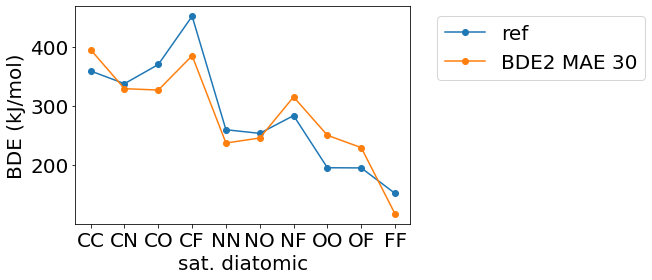

In [37]:
comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
plt.rcParams['font.size'] = 20

plt.plot(comps, ref_bde, '-o', label = 'ref')
# plt.plot(comps, bde_fit, '-o', label = f' BDE3 MAE {np.round(mae,2)}')

# plt.plot(comps, bde_fit_ni, '-o', label = f'BDE1 MAE {np.round(mae_ni,2)}')

# plt.plot(comps, bde_fit_nalpha, '-o', label = f'BDE2 MAE {np.round(mae_nalpha,2)}')
# plt.plot(comps, bde_fit_naprime, '-o', label = f'BDE4 MAE {np.round(mae_naprime,2)}')

plt.plot(comps, bde_fit_d, '-o', label = f'BDE2 MAE {np.round(30,2)}')


plt.legend()
plt.ylabel('BDE (kJ/mol)')
plt.xlabel('sat. diatomic')
plt.legend(bbox_to_anchor = (1.05,1))

$BDE = a_z + b_z \cdot Z' + a_{z'} + b_{z'} \cdot Z + E_\text{nuc}(Z, Z')$

Express $a_z$ and $b_z$ as linear functions in $f(Z)$

$BDE 1 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2 b' Z Z' + E_\text{nuc}(Z, Z')$ assume that in the fits for $a$ and $b$ intercept = 0

$BDE 2 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2 b' Z Z' + a' (Z + Z') + E_\text{nuc}(Z, Z')$ assume that in the fit for $a$ intercept = 0

$BDE 3 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2\alpha + 2 b' Z Z' + a' (Z + Z') + E_\text{nuc}(Z, Z')$ use intercepts from the fits

$BDE 4 = -\frac{\beta}{2} (Z^{7/3} + Z'^{7/3}) + 2\alpha + 2 b' Z Z' + E_\text{nuc}(Z, Z')$ assume that in the fit for $b$ intercept = 0

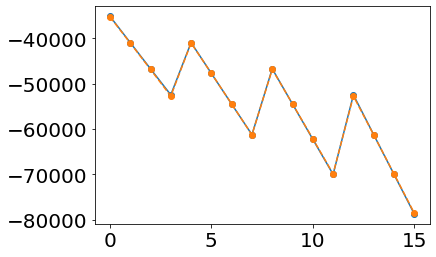

In [70]:
Z = np.array([6,7,8,9])
Z_array = []
for z1 in Z:
    for z2 in Z:
        Z_array.append([z1, z2])
Z_array = np.array(Z_array)

ebfe_el_ni = ebfe_fit_ni(Z_array, out_ni[0][0], out_ni[0][1])
plt.plot(ebfe_el_ni, '-o')
ebfe_fit_el_ai = ebfe_fit(Z_array, out[0][0], out[0][1], out[0][2], out[0][3])
plt.plot(ebfe_fit_el_ai, '--o')

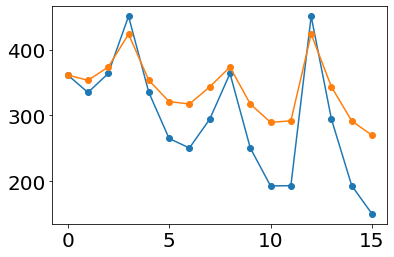

In [82]:
plt.plot(-ebfe_fit_el_ai-nuc_diatomics_all, '-o')

# plt.plot(-(-ebfe_el_ni-nuc_diatomics_all)+shift, '-o')

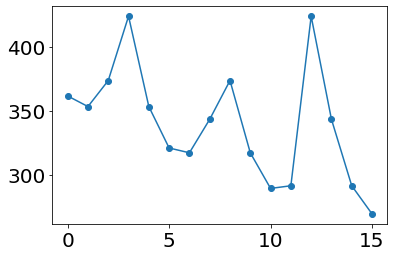

In [81]:
shift = (-ebfe_fit_el_ai-nuc_diatomics_all)[0] - -(-ebfe_el_ni-nuc_diatomics_all)[0]
plt.plot(-(-ebfe_el_ni-nuc_diatomics_all)+shift, '-o')

473.5577578081575

In [67]:
ebfe_fit(Z_array, out[0][0], out[0][1], out[0][2], out[0][3])

array([-35214.36785962, -40996.48125574, -46834.15555575, -52729.92484024,
       -40996.48125574, -47703.42549272, -54465.93063361, -61286.53075898,
       -46834.15555575, -54465.93063361, -62153.26661537, -69898.69758161,
       -52729.92484024, -61286.53075898, -69898.69758161, -78568.95938872])

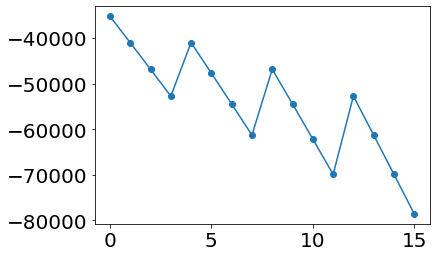

In [54]:
Z = np.array([6,7,8,9])
Z_array = []
for z1 in Z:
    for z2 in Z:
        Z_array.append([z1, z2])
Z_array = np.array(Z_array)


In [61]:
nuc_diatomics_all = []

for s in ['CC','CN','CO','CF', 'CN', 'NN','NO','NF', 'CO', 'NO', 'OO', 'OF', 'CF', 'NF', 'OF', 'FF']:
#     print(s)
    nuc_diatomics_all.append(get_nuc_rep(f'/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/{s}/{s}.xyz', 0)*2600)
    
# binding_nuc_all = dict()
# for k in nuc_diatomics_all.keys():
#     binding_nuc_all[k] = nuc_diatomics_all[k]*2600#-nuc_frag[k[0]]-nuc_frag[k[1]]

nuc_diatomics_all

[34852.72406080705,
 40661.511263745575,
 46470.2986271903,
 52279.08613988504,
 40661.511263745575,
 47438.42997446622,
 54215.34834279035,
 60992.26694514232,
 46470.2986271903,
 54215.34834279035,
 61960.39816936382,
 69705.44763318235,
 52279.08613988504,
 60992.26694514232,
 69705.44763318235,
 78418.62882824495]

In [58]:
s

'OFFF'